In [1]:
import functools
import itertools
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_hub as hub

from tqdm import trange

2025-11-30 07:46:12.876876: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-30 07:46:12.876902: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-30 07:46:12.877946: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-30 07:46:12.883173: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/xy/Desktop/ml/TF/legacy/lib/python3.10/site-pac

2025-11-30 07:46:14.357713: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-30 07:46:14.393543: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-30 07:46:14.395288: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

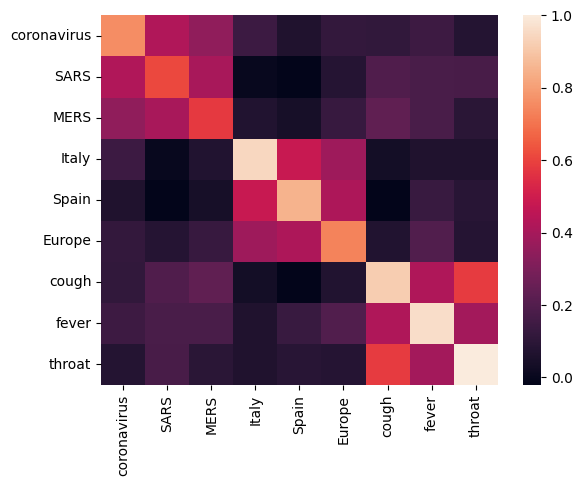

In [2]:
# Use the inner product between two embedding vectors as the similarity measure
def plot_correlation(labels, features):
  corr = np.inner(features, features)
  corr /= np.max(corr)
  sns.heatmap(corr, xticklabels=labels, yticklabels=labels)

# Generate embeddings for some terms
queries = [
  # Related viruses
  'coronavirus', 'SARS', 'MERS',
  # Regions
  'Italy', 'Spain', 'Europe',
  # Symptoms
  'cough', 'fever', 'throat'
]

module = hub.load('https://tfhub.dev/tensorflow/cord-19/swivel-128d/3')
embeddings = module(queries)

plot_correlation(queries, embeddings)

In [3]:
builder = tfds.builder(name='scicite')
builder.download_and_prepare()
train_data, validation_data, test_data = builder.as_dataset(
    split=('train', 'validation', 'test'),
    as_supervised=True)

In [4]:
NUM_EXAMPLES =   10

TEXT_FEATURE_NAME = builder.info.supervised_keys[0]
LABEL_NAME = builder.info.supervised_keys[1]

def label2str(numeric_label):
  m = builder.info.features[LABEL_NAME].names
  return m[numeric_label]

data = next(iter(train_data.batch(NUM_EXAMPLES)))


pd.DataFrame({
    TEXT_FEATURE_NAME: [ex.numpy().decode('utf8') for ex in data[0]],
    LABEL_NAME: [label2str(x) for x in data[1]]
})

2025-11-30 07:46:16.030360: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


,string,label
0,The finding that BMI is closely related to TBF...,result
1,The average magnitude of the NBR increases wit...,background
2,It has been reported that NF-κB activation can...,result
3,", 2008; Quraan and Cheyne, 2008; Quraan and Ch...",background
4,"5B), but, interestingly, they shared conserved...",background
5,Some investigators have noted an association o...,background
6,"In our previous study, it is documented that b...",background
7,These subjects have intact cognitive function ...,background
8,Another study reported improved knee function ...,background
9,C. Data Analysis Transcription Speech samples ...,method


In [5]:
EMBEDDING = 'https://tfhub.dev/tensorflow/cord-19/swivel-128d/3' 
TRAINABLE_MODULE = False 

hub_layer = hub.KerasLayer(EMBEDDING, input_shape=[], 
                           dtype=tf.string, trainable=TRAINABLE_MODULE)

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(3))
model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               17301632  
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 17302019 (132.00 MB)
Trainable params: 387 (1.51 KB)
Non-trainable params: 17301632 (132.00 MB)
_________________________________________________________________


In [6]:
EPOCHS = 35
BATCH_SIZE = 32

history = model.fit(train_data.shuffle(10000).batch(BATCH_SIZE),
                    epochs=EPOCHS,
                    validation_data=validation_data.batch(BATCH_SIZE),
                    verbose=1)

Epoch 1/35
 28/257 [==>...........................] - ETA: 0s - loss: 1.1731 - accuracy: 0.3571  

2025-11-30 07:46:28.186981: I external/local_xla/xla/service/service.cc:168] XLA service 0x724882fd65f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-30 07:46:28.187000: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-11-30 07:46:28.191443: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-30 07:46:28.205882: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1764485188.253015   19065 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


257/257 [==============================] - 1s 2ms/step - loss: 0.9225 - accuracy: 0.5832 - val_loss: 0.7923 - val_accuracy: 0.6856
Epoch 2/35
257/257 [==============================] - 1s 2ms/step - loss: 0.7086 - accuracy: 0.7148 - val_loss: 0.6818 - val_accuracy: 0.7478
Epoch 3/35
257/257 [==============================] - 1s 2ms/step - loss: 0.6325 - accuracy: 0.7492 - val_loss: 0.6338 - val_accuracy: 0.7609
Epoch 4/35
257/257 [==============================] - 1s 2ms/step - loss: 0.5955 - accuracy: 0.7674 - val_loss: 0.6078 - val_accuracy: 0.7609
Epoch 5/35
257/257 [==============================] - 1s 2ms/step - loss: 0.5735 - accuracy: 0.7774 - val_loss: 0.5926 - val_accuracy: 0.7653
Epoch 6/35
257/257 [==============================] - 1s 2ms/step - loss: 0.5599 - accuracy: 0.7802 - val_loss: 0.5844 - val_accuracy: 0.7707
Epoch 7/35
257/257 [==============================] - 1s 2ms/step - loss: 0.5500 - accuracy: 0.7847 - val_loss: 0.5748 - val_accuracy: 0.7707
Epoch 8/35
257/25

In [7]:
from matplotlib import pyplot as plt
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

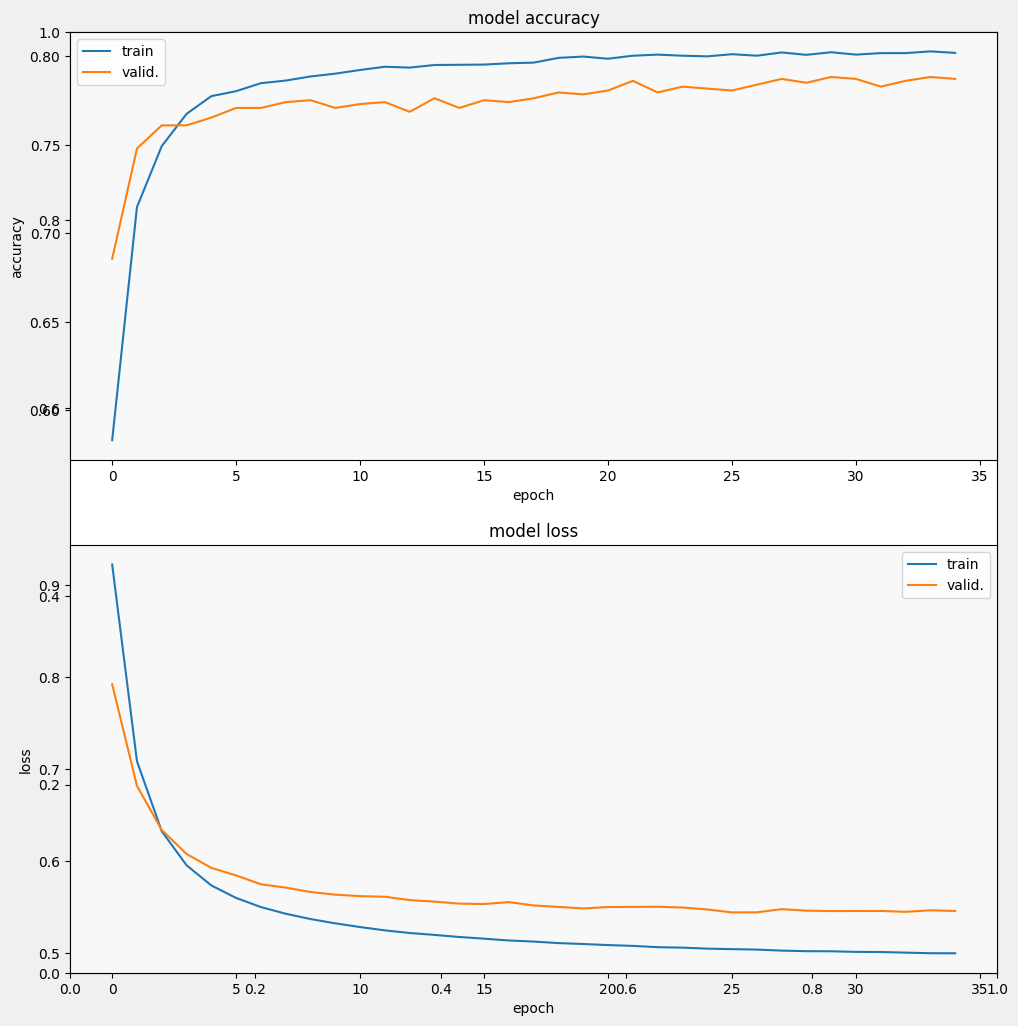

In [8]:
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [9]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print('%s: %.3f' % (name, value))

4/4 - 0s - loss: 0.5337 - accuracy: 0.7891 - 80ms/epoch - 20ms/step
loss: 0.534
accuracy: 0.789


In [10]:
prediction_dataset = next(iter(test_data.batch(20)))

prediction_texts = [ex.numpy().decode('utf8') for ex in prediction_dataset[0]]
prediction_labels = [label2str(x) for x in prediction_dataset[1]]

predictions = [
    label2str(x) for x in np.argmax(model.predict(prediction_texts), axis=-1)]


pd.DataFrame({
    TEXT_FEATURE_NAME: prediction_texts,
    LABEL_NAME: prediction_labels,
    'prediction': predictions
})

1/1 [==============================] - 0s 75ms/step


,string,label,prediction
0,"The diffraction grating, LED, and split detect...",background,method
1,Our ideas are based on a previous paper [4] de...,background,method
2,Our finding is consistent with the literature ...,result,result
3,Test scores from each of the cognitive domains...,method,method
4,The optimization algorithm was set to maximize...,method,method
5,To quantify the extent of substitution saturat...,method,method
6,Examples of gesture control are based on the e...,method,method
7,The identification of these features has been ...,method,background
8,Postulated mechanisms for observed effects of ...,background,background
9,The right inferior phrenic artery is the most ...,background,background
